In [54]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Math, Latex

#print(plt.style.available)
plt.style.use('ggplot')

### Übungsblatt 5

#### 5.1 Hashfunktion djb2

Es soll die Hashfunktion `djb2` implementiert werden. Die dafür zu verwendende Funktion ist

$X_i := (a * X_{i-1}) + c_i$  (mod $M$)

mit den Parametern $X_0 = 5381$, $a = 33$ und $M = 2^{32}$.

In [55]:
def djb2(value, M=np.power(2, 32)):
    x_i = 5381
    for i in range(len(value)):
        char = value[i]
        x_i = ((33 * x_i) + ord(char)) % M
    return x_i

print('djb2 of "Hallo Welt": %d' % djb2('Hallo Welt'))

djb2 of "Hallo Welt": 2793804081


#### 5.2 Test Hash

Kollisionen:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ersten 10 Hashes und Namen in dht[16]
(6, ['TWILA'])
(13, ['AUDIE', 'LORRI'])
(17, ['ULRIKE'])
(20, ['ERICKA'])
(33, ['ALAN'])
(53, ['ALBA'])
(57, ['ALETHEA'])
(85, ['TAMIE'])
(91, ['MAMMIE'])
(94, ['ALEXANDRIA'])


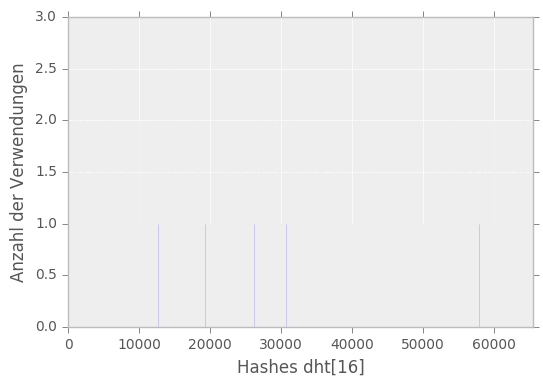

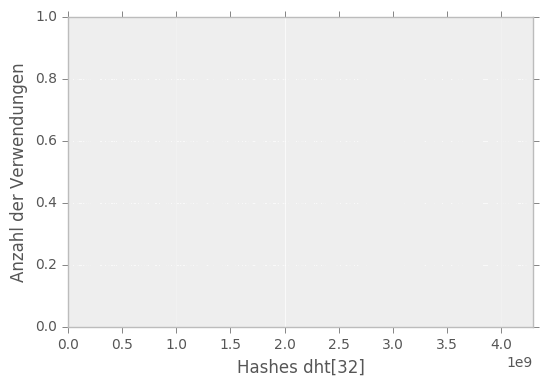

In [56]:
import matplotlib.mlab as mlab
from itertools import groupby

dht = {
    16: [],
    32: []
}

# hashes erstellen
with open('exercise5_names.txt', mode='r') as names:
    for name in names:
        name = name.strip()
        dht[16].append((djb2(name, np.power(2, 16)), name))
        dht[32].append((djb2(name), name))

# ausgabe der kollisionen
def group_hashes(dht):
    dht = sorted(dht, key=lambda k: k[0])
    result = []
    for k, g in groupby(dht, key=lambda k: k[0]):
        names = list(g)
        result.append((k, [n[1] for n in names]))
    return result

dht = {
    16: group_hashes(dht[16]),
    32: group_hashes(dht[32])
}

def count_hash_dups(dht):
    count = 0
    for _hash, names in dht:
        if len(names) > 1:
            count += 1
    return count

print('Kollisionen:')
display(Math(r'M = 2^{16}: %d' % count_hash_dups(dht[16])))
display(Math(r'M = 2^{32}: %d' % count_hash_dups(dht[32])))

heads = 10
print('Ersten %d Hashes und Namen in dht[16]' % heads)
for i in range(heads):
    print(dht[16][i])
    
plt.style.use('bmh')

plt.bar([x[0] for x in dht[16]], [len(y[1]) for y in dht[16]], width=.1)
plt.xlim(0, np.power(2, 16))
plt.xlabel('Hashes dht[16]')
plt.ylabel('Anzahl der Verwendungen')
plt.show()

plt.bar([x[0] for x in dht[32]], [len(y[1]) for y in dht[32]], width=.1)
plt.xlim(0, np.power(2, 32))
plt.xlabel('Hashes dht[32]')
plt.ylabel('Anzahl der Verwendungen')
plt.show()

plt.style.use('ggplot')

#### 5.3 Distanzen $\Delta X$

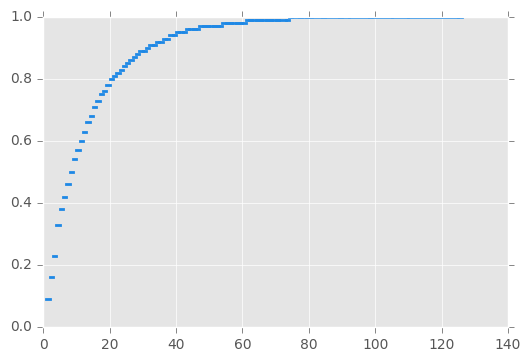

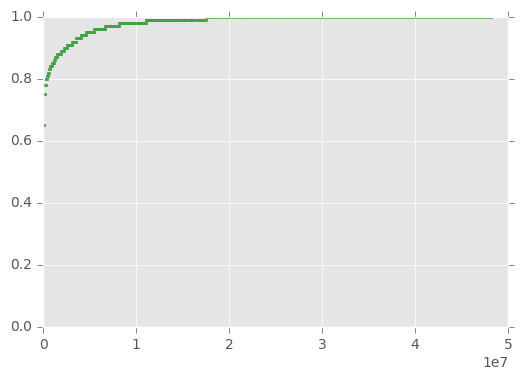

In [57]:
def ecdf(values, color='#1e88e5'):
    
    values = sorted(values)

    unique_values = sorted(list(set(values)))

    cumsum_values = []
    for u in unique_values:
        cumsum_values.append((u, len([1 for _ in values if _ <= u])))

    y = np.round([c / len(values) for t, c in cumsum_values], decimals=2)

    for i in range(len(unique_values)):
        x_0 = unique_values[i]
        x_1 = unique_values[i + 1] if i < len(unique_values) - 1 else unique_values[i] + 1
        plt.plot([x_0, x_1], [y[i], y[i]], color=color, linestyle='-')

# normalerweise müsste für np.diff noch ein sorted hinzugefügt
# werden. das ist aber durch die vorige gruppierung
# der dht bereits geschehen
hash_diffs = {
    16: np.diff([i[0] for i in dht[16]]),
    32: np.diff([i[0] for i in dht[32]]),
}
ecdf(hash_diffs[16])
plt.show()

ecdf(hash_diffs[32], color='#43a047')
plt.show()

#### 5.4 Curve Fit $\Delta D$

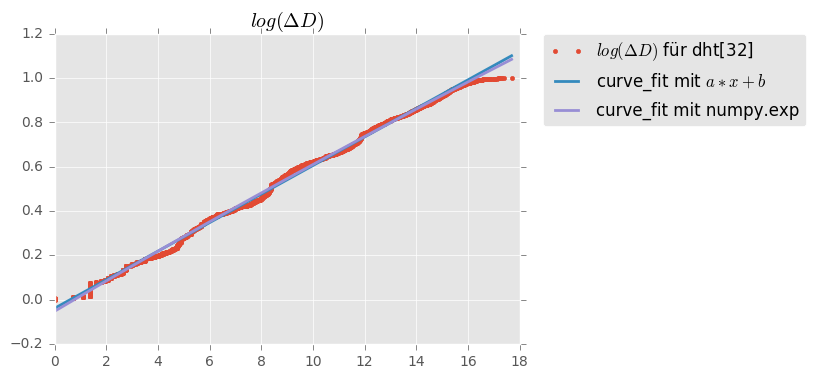

In [58]:
from scipy.optimize import curve_fit

log_dd = {
    #16: np.log(sorted(hash_diffs[16])),
    32: np.log(sorted(hash_diffs[32]))
}

def plot_fit(func, label, x, y):
    """Fuehrt ein curve fit mit gegebener Funktion und
    x und y Werten aus. Das Ergebnis wird mit dem 
    gegebenen Label geplottet.
    """
    popt, pcov = curve_fit(func, x, y)
    y_i = [func(_x, *popt) for _x in x]
    plt.plot(x, y_i, label=label)
    
def exp_func(x, a, b, c):
    return a * np.exp(-b * x) + c

for l in log_dd:
    y = np.arange(len(log_dd[l])) / len(log_dd[l])
    plt.plot(log_dd[l], y, '.', label='$log(\Delta D)$ für dht[%d]' % l)
    
    # curve fit mit linearem polynom
    plot_fit(lambda x, a, b: a + b*x, 'curve_fit mit $a * x + b$', log_dd[l], y)
    
    # curve fit mit exponentialfunktion
    plot_fit(exp_func, 'curve_fit mit numpy.exp', log_dd[l], y)
    
plt.title('$log(\Delta D)$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

#### 5.5 Peers

ID: 241148815    Objekte: 461590410
ID: 702739225    Objekte: 1214819224
ID: 1917558449   Objekte: 546748653
ID: 2464307102   Objekte: 336999953
ID: 2801307055   Objekte: 82180613
ID: 2883487668   Objekte: 18466408
ID: 2901954076   Objekte: 112250426
ID: 3014204502   Objekte: 75896615
ID: 3090101117   Objekte: 907901923
ID: 3998003040   Objekte: 538113071


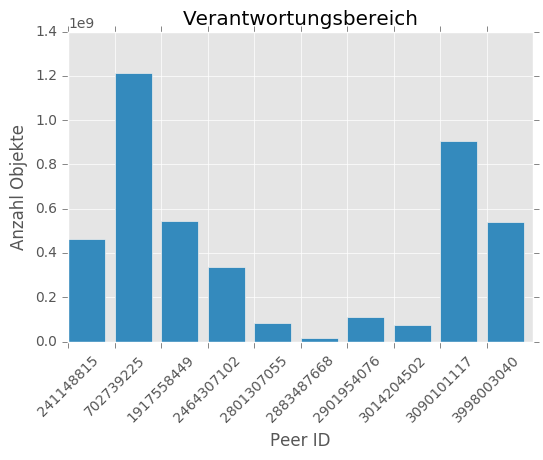

In [59]:
import random

num_peers = 10
peers = []
for i in range(num_peers):
    peers.append({'id': random.randint(0, np.power(2, 32))})
peers = sorted(peers, key=lambda p: p['id'])

last_peer = None
for i in range(len(peers)):
    current_peer = peers[i]
    if last_peer is not None:
        peers[i - 1]['objects'] = current_peer['id'] - last_peer['id']
    last_peer = current_peer
peers[-1]['objects'] = np.power(2, 32) - last_peer['id'] + peers[0]['id']

for peer in peers:
    print('ID: {:<12d} Objekte: {:d}'.format(peer['id'], peer['objects']))

plt.bar([i for i in range(num_peers)], 
        [peer['objects'] for peer in peers])

plt.xticks([i for i in range(num_peers)],
           [peer['id'] for peer in peers], 
           rotation=45)
plt.title('Verantwortungsbereich')
plt.xlabel('Peer ID')
plt.ylabel('Anzahl Objekte')
plt.show()

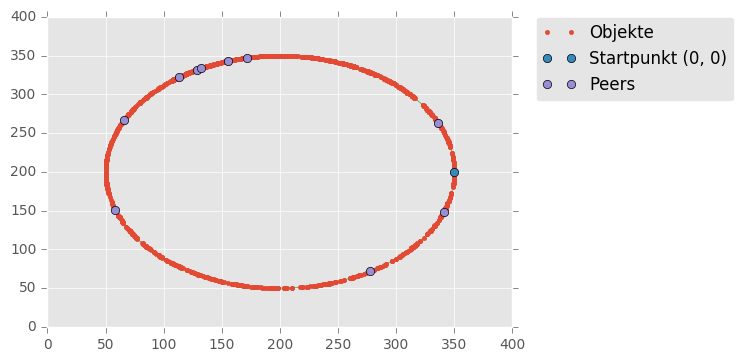

In [60]:
x_min = 0
x_max = 400
y_min = 0
y_max = 400

fig, ax = plt.subplots()
plt.axis([x_min, x_max, y_min, y_max])

circle_x = (x_max - x_min) / 2.
circle_y = (y_max - y_min) / 2.

radius = 150

# zeichnen eines kreises der den gesamten raum 0 <= n <= 2^32 angibt
circ = plt.Circle((circle_x, circle_y), radius=radius, color='#43a047', fill=False)
ax.add_patch(circ)

def coords(hashes):
    """Liefert die Polarkoordinaten der gegebenen Hashes auf dem zuvor
    berechneten Kreis. Das Resultat ist ein zwei dimensionales Array
    mit den X- und Y-Koordinaten ([[x1, x2...], [y1, y2...]])
    """
    result = [[], []]
    for h in hashes:
        # winkel auf dem kreis ausgehend vom startpunkt im uhrzeigersinn (-)
        angle = -h / np.power(2, 32) * 360

        # bogenmaß des winkels bestimmen
        rad_angle = angle / 180. * np.pi

        # x = cos(a) * radius 
        # y = sin(a) * radius
        # verschiebung, so dass die koordinaten des kreises passen
        x = np.cos(rad_angle) * radius + 200
        y = np.sin(rad_angle) * radius + 200
        result[0].append(x)
        result[1].append(y)
    return result

# plotten der objekte
obj_coords = coords([obj[0] for obj in dht[32]])
plt.plot(obj_coords[0], obj_coords[1], '.', label='Objekte')

# startpunkt des rings
plt.plot(350, 200, 'o', label='Startpunkt (0, 0)')

# plotten der peers
peer_coords = coords([peer['id'] for peer in peers])
plt.plot(peer_coords[0], peer_coords[1], 'o', label='Peers')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()